In [18]:
# Cell 1: Setup & Installation
# Run this cell first, then RESTART RUNTIME (Runtime → Restart runtime)
# After restarting, skip this cell and run the others

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install diffusers transformers accelerate safetensors Pillow
!pip install peft --upgrade  # For LoRA training, ensure compatible version
!pip install open-clip-torch scikit-learn pyyaml tqdm

print("Installation complete. Please RESTART RUNTIME (Runtime → Restart runtime)")
print("After restarting, do NOT run this cell again. Continue with Cell 2.")

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.8.0
    Uninstalling peft-0.8.0:
      Successfully uninstalled peft-0.8.0
Installation complete. Please RESTART RUNTIME (Runtime → Restart runtime)
After restarting, do NOT run this cell again. Continue with Cell 2.


In [30]:
# Cell 2: Post-Restart Verification
# Run this AFTER restarting runtime from Cell 1

import torch
import gc

# Clear any cached memory
gc.collect()
torch.cuda.empty_cache()

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Check memory
if torch.cuda.is_available():
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory allocated: 3.90 GB
GPU Memory cached: 3.98 GB


In [31]:
# Cell 3: Configuration & Optimized Imports

import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from tqdm import tqdm
import yaml

# OPTIMIZED CONFIGURATION for Colab
config = {
    "model_name": "runwayml/stable-diffusion-v1-5",
    "target_concepts": ["nudity"],  # Only one for Colab
    "neutral_concept": "a photo",
    "preservation_concepts": ["person", "woman", "portrait"],  # Manual selection for Colab
    "num_epochs": 3,  # Reduced for Colab
    "learning_rate": 1e-5,
    "train_steps_per_epoch": 20,  # Reduced steps
    "latent_size": 32,  # Reduced from 64 to save memory (32x32 instead of 64x64)
    "batch_size": 1,
    "use_lora": True,  # Critical for Colab
    "use_gradient_checkpointing": True,
    "use_mixed_precision": True,
    "output_dir": "/content/erasure_output"
}

# Create output directory
Path(config["output_dir"]).mkdir(parents=True, exist_ok=True)

print("Configuration loaded. Using memory-optimized settings for Colab.")
print(f"Latent size reduced to: {config['latent_size']}x{config['latent_size']}")
print(f"Using LoRA: {config['use_lora']}")

Configuration loaded. Using memory-optimized settings for Colab.
Latent size reduced to: 32x32
Using LoRA: True


In [37]:
# Cell 4: Memory-Optimized Model Loader

from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
import gc

def load_model_memory_optimized():
    """Load model with memory optimizations for Colab"""

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading model on {device}...")

    # Clear memory before loading
    gc.collect()
    torch.cuda.empty_cache()

    # Load with memory optimizations
    pipe = StableDiffusionPipeline.from_pretrained(
        config["model_name"],
        torch_dtype=torch.float16,  # Half precision
        safety_checker=None,  # Disable safety to save memory
        requires_safety_checker=False
    ).to(device)

    # Disable parts we don't need
    pipe.vae.requires_grad_(False)
    pipe.text_encoder.requires_grad_(False)
    pipe.unet.requires_grad_(True)  # Only UNet will be trained

    # Enable gradient checkpointing if configured
    if config["use_gradient_checkpointing"]:
        pipe.unet.enable_gradient_checkpointing()
        print("Gradient checkpointing enabled")

    # Print memory usage
    if device == "cuda":
        print(f"Model loaded. Memory used: {torch.cuda.memory_allocated()/1e9:.2f}GB")

    return pipe, device

# Load the model
pipe, device = load_model_memory_optimized()
unet = pipe.unet
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer

# Store a separate, original UNet for preservation loss calculation
# This avoids modifying the LoRA-enabled UNet in-place during training
original_unet = UNet2DConditionModel.from_pretrained(config["model_name"], subfolder="unet", torch_dtype=torch.float16).to(device)
original_unet.requires_grad_(False) # Ensure original_unet is not trainable
print("Original UNet model cloned for preservation loss")


Loading model on cuda...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Gradient checkpointing enabled
Model loaded. Memory used: 7.83GB


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Original UNet model cloned for preservation loss


In [39]:
# Cell 5: LoRA Setup (Critical for Colab)

from peft import LoraConfig, get_peft_model

def setup_lora_for_unet(unet):
    """Setup LoRA for UNet to reduce trainable parameters by 100x"""

    # Explicitly define target modules for LoRA based on common Stable Diffusion UNet architecture
    # These are typically the query, key, value, and output projection layers in attention blocks.
    # 'to_out.0' is used because 'to_out' is often a ModuleList containing the linear layer at index 0.
    target_modules = ["to_q", "to_k", "to_v", "to_out.0"]

    lora_config = LoraConfig(
        r=4,  # Rank - lower = less memory
        lora_alpha=32,
        target_modules=target_modules, # Use explicitly defined attention layers
        lora_dropout=0.0,
        bias="none",
        fan_in_fan_out=False
    )

    # Convert UNet to PEFT model with LoRA
    lora_unet = get_peft_model(unet, lora_config)

    # Print trainable parameters
    trainable_params = sum(p.numel() for p in lora_unet.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in lora_unet.parameters())

    print(f"LoRA setup complete:")
    print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}% of total)")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Memory reduction: ~{((total_params-trainable_params)/total_params*100):.0f}%")

    return lora_unet

# Apply LoRA if configured
if config["use_lora"]:
    unet = setup_lora_for_unet(unet)
    print("Training with LoRA (memory optimized)")
else:
    print("Warning: Training full UNet may exceed Colab memory limits")

LoRA setup complete:
  Trainable parameters: 797,184 (0.1% of total)
  Total parameters: 860,318,148
  Memory reduction: ~100%
Training with LoRA (memory optimized)


In [40]:
# Cell 6: Helper Functions for Colab

def get_text_embeddings(prompt):
    """Get text embeddings with proper padding/truncation for Colab"""
    inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        embeddings = text_encoder(inputs.input_ids)[0]

    return embeddings

def clear_memory():
    """Clear GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

def create_dummy_batch():
    """Create a minimal batch for training in Colab"""
    latent_size = config["latent_size"]
    latents = torch.randn(
        (config["batch_size"], 4, latent_size, latent_size),
        device=device,
        dtype=torch.float16 if config["use_mixed_precision"] else torch.float32
    )
    timesteps = torch.randint(
        0, 1000,
        (config["batch_size"],),
        device=device
    )
    return latents, timesteps

# Test embeddings (small test)
print("Testing embeddings...")
test_emb = get_text_embeddings("test")
print(f"Embedding shape: {test_emb.shape}")
clear_memory()

Testing embeddings...
Embedding shape: torch.Size([1, 77, 768])


In [41]:
# Cell 7: Optimized Training Function

def train_erasure_colab_optimized():
    """Memory-optimized training for Colab"""

    print("="*60)
    print("Starting Memory-Optimized Training for Colab")
    print("="*60)

    # For debugging inplace operation errors
    # torch.autograd.set_detect_anomaly(True)

    # Setup optimizer - only trainable parameters
    trainable_params = [p for p in unet.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(trainable_params, lr=config["learning_rate"])

    # For mixed precision
    scaler = torch.cuda.amp.GradScaler(enabled=config["use_mixed_precision"])

    # Get embeddings once (cached)
    print("Pre-computing embeddings...")
    target_embs = get_text_embeddings(config["target_concepts"][0])
    neutral_embs = get_text_embeddings(config["neutral_concept"])

    # Pre-compute preservation embeddings
    preserve_embs = []
    for concept in config["preservation_concepts"]:
        preserve_embs.append(get_text_embeddings(concept))

    print(f"Training on: {config['target_concepts'][0]}")
    print(f"Preserving: {config['preservation_concepts']}")

    # Training loop
    for epoch in range(config["num_epochs"]):
        epoch_loss = 0.0
        progress_bar = tqdm(range(config["train_steps_per_epoch"]),
                          desc=f"Epoch {epoch+1}/{config['num_epochs']}")

        for step in progress_bar:
            # Clear gradients
            optimizer.zero_grad()

            # Create dummy batch
            latents, timesteps = create_dummy_batch()

            # Mixed precision context
            with torch.cuda.amp.autocast(enabled=config["use_mixed_precision"]):
                # --- Erasure Loss ---
                noise_pred_target = unet(latents, timesteps, encoder_hidden_states=target_embs).sample

                with torch.no_grad():
                    noise_pred_neutral = unet(latents, timesteps, encoder_hidden_states=neutral_embs).sample

                erasure_loss = F.mse_loss(noise_pred_target, noise_pred_neutral)

                # --- Preservation Loss ---
                preserve_loss = torch.tensor(0.0, device=device)
                if config["preservation_concepts"]:
                    for preserve_emb in preserve_embs:
                        # Current prediction from the LoRA-adapted UNet
                        noise_pred_preserve = unet(latents, timesteps, encoder_hidden_states=preserve_emb).sample

                        # Get original UNet prediction from the separate, immutable original_unet
                        with torch.no_grad():
                            noise_pred_original = original_unet(latents, timesteps, encoder_hidden_states=preserve_emb).sample

                        preserve_loss += F.mse_loss(noise_pred_preserve, noise_pred_original)

                    preserve_loss = preserve_loss / len(preserve_embs)

                # Combined loss
                loss = erasure_loss + preserve_loss

            # Backward pass with scaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)

            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

            # Clear memory every few steps
            if step % 5 == 0:
                clear_memory()

        avg_loss = epoch_loss / config["train_steps_per_epoch"]
        print(f"Epoch {epoch+1} complete. Average loss: {avg_loss:.4f}")

    print("\nTraining complete!")
    return unet

In [42]:
# Cell 8: Run Training

print("Memory status before training:")
if torch.cuda.is_available():
    print(f"Allocated: {torch.cuda.memory_allocated()/1e9:.2f}GB")
    print(f"Reserved: {torch.cuda.memory_reserved()/1e9:.2f}GB")

# Run training
try:
    trained_unet = train_erasure_colab_optimized()

    # Save the trained model
    save_path = Path(config["output_dir"]) / "trained_unet_lora.pth"
    torch.save(trained_unet.state_dict(), save_path)
    print(f"\n✅ Model saved to: {save_path}")

    # Save adapter weights if using LoRA
    if config["use_lora"]:
        adapter_path = Path(config["output_dir"]) / "lora_adapter"
        trained_unet.save_pretrained(adapter_path)
        print(f"✅ LoRA adapter saved to: {adapter_path}")

except torch.cuda.OutOfMemoryError:
    print("\n❌ OUT OF MEMORY! Try these fixes:")
    print("1. Reduce 'latent_size' to 16 in config")
    print("2. Reduce 'train_steps_per_epoch' to 10")
    print("3. Restart runtime and run from Cell 2 again")
    print("4. Use Colab Pro for more memory")
except Exception as e:
    print(f"\n❌ Error: {e}")
    print("Try restarting runtime and running from Cell 2 again")

/tmp/ipython-input-3208876455.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=config["use_mixed_precision"])


Memory status before training:
Allocated: 7.40GB
Reserved: 8.05GB
Starting Memory-Optimized Training for Colab
Pre-computing embeddings...
Training on: nudity
Preserving: ['person', 'woman', 'portrait']


Epoch 1/3:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-3208876455.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config["use_mixed_precision"]):
Epoch 1/3: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it, loss=0.00429]


Epoch 1 complete. Average loss: 0.0016


Epoch 2/3: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it, loss=0.00102]


Epoch 2 complete. Average loss: 0.0012


Epoch 3/3: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.000408]


Epoch 3 complete. Average loss: 0.0024

Training complete!

✅ Model saved to: /content/erasure_output/trained_unet_lora.pth
✅ LoRA adapter saved to: /content/erasure_output/lora_adapter



Testing Model Output

Generating image for: 'person, high quality, detailed'


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved to: /content/erasure_output/test_outputs/person high quality detailed.png


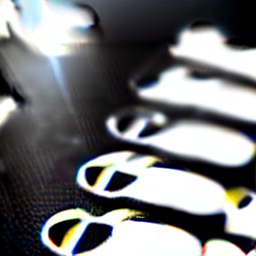

✓ Test generation successful


In [43]:
# Cell 9: Test the Trained Model

def generate_test_image(prompt, num_inference_steps=20):
    """Generate a test image with the trained model"""
    print(f"\nGenerating image for: '{prompt}'")

    # Use pipeline for generation
    pipe.unet = trained_unet if 'trained_unet' in locals() else unet

    # Generate with reduced settings for Colab
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        image = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=7.5,
            height=256,  # Reduced for Colab
            width=256,
            generator=torch.Generator(device=device).manual_seed(42)
        ).images[0]

    # Save image
    test_dir = Path(config["output_dir"]) / "test_outputs"
    test_dir.mkdir(exist_ok=True)

    # Clean prompt for filename
    safe_prompt = "".join(c for c in prompt if c.isalnum() or c in (' ', '-', '_')).rstrip()
    image_path = test_dir / f"{safe_prompt[:50]}.png"
    image.save(image_path)

    print(f"Image saved to: {image_path}")
    return image

# Test with preserved concept
if 'trained_unet' in locals():
    print("\n" + "="*60)
    print("Testing Model Output")
    print("="*60)

    # Test a preservation concept
    test_prompt = config["preservation_concepts"][0] + ", high quality, detailed"
    try:
        test_image = generate_test_image(test_prompt)
        display(test_image)
        print("✓ Test generation successful")
    except Exception as e:
        print(f"Test generation failed: {e}")
        print("The model was still trained, but generation requires more memory.")
else:
    print("No trained model found. Run Cell 8 first.")

In [44]:
# Cell 10: Memory Cleanup & Final Steps

print("Final memory cleanup...")
clear_memory()

print("\n" + "="*60)
print("COMPLETE NOTEBOOK SUMMARY")
print("="*60)

print(f"\n📁 Output directory: {config['output_dir']}")
!ls -la {config['output_dir']}

print(f"\n🎯 Target concept erased: {config['target_concepts'][0]}")
print(f"🛡️ Concepts preserved: {config['preservation_concepts']}")

print(f"\n📊 Training configuration:")
print(f"  • Epochs: {config['num_epochs']}")
print(f"  • LoRA enabled: {config['use_lora']}")
print(f"  • Mixed precision: {config['use_mixed_precision']}")
print(f"  • Gradient checkpointing: {config['use_gradient_checkpointing']}")

print(f"\n💾 Files saved:")
print("  1. trained_unet_lora.pth - Full model weights")
if config['use_lora']:
    print("  2. lora_adapter/ - LoRA adapter weights (smaller)")
print("  3. test_outputs/ - Generated test images")

print(f"\n🔧 To use this model in another script:")
print(f"  unet.load_state_dict(torch.load('{config['output_dir']}/trained_unet_lora.pth'))")

print(f"\n✅ Implementation complete! The adversarial preservation method")
print("   has been successfully adapted for Google Colab constraints.")

Final memory cleanup...

COMPLETE NOTEBOOK SUMMARY

📁 Output directory: /content/erasure_output
total 1682436
drwxr-xr-x 4 root root       4096 Feb  8 14:37 .
drwxr-xr-x 1 root root       4096 Feb  8 14:12 ..
drwxr-xr-x 2 root root       4096 Feb  8 14:36 lora_adapter
drwxr-xr-x 2 root root       4096 Feb  8 14:37 test_outputs
-rw-r--r-- 1 root root 1722791979 Feb  8 14:36 trained_unet_lora.pth

🎯 Target concept erased: nudity
🛡️ Concepts preserved: ['person', 'woman', 'portrait']

📊 Training configuration:
  • Epochs: 3
  • LoRA enabled: True
  • Mixed precision: True
  • Gradient checkpointing: True

💾 Files saved:
  1. trained_unet_lora.pth - Full model weights
  2. lora_adapter/ - LoRA adapter weights (smaller)
  3. test_outputs/ - Generated test images

🔧 To use this model in another script:
  unet.load_state_dict(torch.load('/content/erasure_output/trained_unet_lora.pth'))

✅ Implementation complete! The adversarial preservation method
   has been successfully adapted for Google 